# Load Variance Problem
## Import Dependencies

In [1]:
# Init Environment
# Autoreload Magic to autoreload external modules
%load_ext autoreload
%autoreload 2

# Numpy and Scipy
import numpy as np
import scipy
import scipy.io

from numpy import inf
from numpy.linalg import norm
from optalg.opt_solver import *

# Gridopt, PFNET and MP-PFNET
import gridopt
import pfnet
import mppfnet
import optalg
from mppfnet.mp_network import MPNetwork
from mppfnet.mp_problem import MPProblem
import pfvis

# Python Multiprocessing
import multiprocessing

# Matplotlib and Seaborn
from matplotlib import rcParams
from matplotlib.pyplot import clf, plot, title, xlabel, ylabel, legend, show, spy
%matplotlib inline
from IPython.display import set_matplotlib_formats
%config InlineBackend.figure_formats=['retina']
import pylab
pylab.rcParams['figure.figsize'] =(16,6)

import seaborn

# CVXPY
import cvxpy

/usr/local/lib/python3.5/site-packages/matplotlib-0+unknown-py3.5-macosx-10.11-x86_64.egg/matplotlib/__init__.py:900: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Construct Problem

In [2]:
mp = MPNetwork(timesteps=24)
mp.load('./data/case32.art')

In [3]:
prices = scipy.io.loadmat('./data/eex_intraday_2010_3600s.mat')['eex_intraday_2010_3600s']
eex_prices = np.array([p[0,0] for p in prices[:, 5][1:]]) * mp.base_power 
mp.set_prices(eex_prices)

In [4]:
mp.load_load_profile_from_csv("./data/Electricity_Profile.csv")

In [5]:
mp.generate_solar_profiles()

In [6]:
mp.set_flags(pfnet.OBJ_BAT, pfnet.FLAG_VARS,pfnet.BAT_PROP_ANY, pfnet.BAT_VAR_E)
mp.set_flags(pfnet.OBJ_BAT, pfnet.FLAG_VARS,pfnet.BAT_PROP_ANY, pfnet.BAT_VAR_P)
mp.set_flags(pfnet.OBJ_BAT,pfnet.FLAG_BOUNDED,pfnet.BAT_PROP_ANY,pfnet.BAT_VAR_P)
mp.set_flags(pfnet.OBJ_BAT,pfnet.FLAG_BOUNDED,pfnet.BAT_PROP_ANY,pfnet.BAT_VAR_E)

In [7]:
p = MPProblem(mp)

In [8]:
p.add_function(pfnet.FUNC_TYPE_NETCON_COST, 1.0)

In [9]:
p.add_constraint(pfnet.CONSTR_TYPE_LBOUND)
p.add_constraint(mppfnet.CONSTR_TYPE_BAT_DYN)

In [10]:
p.analyze()
x = p.get_init_point()
x = p.eval(x)

In [11]:
%aimport pfvis

pfvis.plot_graph(mp.get_network())

## Higher Load Profile Penality $\gamma = 10$

The state vector reads as:
$x = (x (0), \ldots, x(T))$

with $x(t) = (x_0 (t), \ldots, x_n (t))$

In [12]:
x = cvxpy.Variable(mp.get_network().num_vars * mp.timesteps)

Tuning parameter $\gamma$ that scales the penalty of a spiky load profile. A lower $\gamma$ corresponds to a less spiky load profile.

In [13]:
gamma = 1

linear energy cost: $\sum_t^T \sum_i \bar f_i(t, x_i) = \sum_i c_i^\top x_i$

In [14]:
g = p.gphi #/ mp.base_power
cost_scaling_factor = np.maximum(norm(g, ord=inf), 1)
g = g / cost_scaling_factor
energy_cost_obj = g.T * x # energy cost

In [15]:
net_power = np.empty(mp.timesteps, dtype='object')
# the constant part of the power injection is the load and the vargen input
constant_powers = np.zeros((mp.timesteps, mp.get_network().num_buses - 1), dtype='object')
# expressions for the injected power at time t at bus i
power = np.empty(shape=(mp.timesteps, mp.get_network().num_buses - 1), dtype='object')
for t in range(0, mp.timesteps):
    for bus_i in filter(lambda bus: (not bus.is_slack()), mp.get_network().buses):        
        i = bus_i.index
        # constant parts of the injected power (load and vargens)
        constant_powers[t, i] = sum([load.P for load in mp.get_network(time=t).get_bus(i).loads])
        constant_powers[t, i] -= sum([ vargen.P for vargen in mp.get_network(time=t).get_bus(i).vargens]) # vargen power
        power_i_t  = constant_powers[t, i]
        # parts of the injected power that are optimization variables
        power_i_t  -= sum([x[t * mp.get_network().num_vars + gen.index_P] for gen in mp.get_network(time=t).get_bus(i).gens]) # gen power
        power_i_t  += sum([x[t * mp.get_network().num_vars + bat.index_Pc] for bat in mp.get_network(time=t).get_bus(i).bats]) # battery charge
        power_i_t  -= sum([x[t * mp.get_network().num_vars + bat.index_Pd] for bat in mp.get_network(time=t).get_bus(i).bats]) # battery discharge
        power[t, i] = power_i_t
    # the net power is the sum other all buses at a time t
    net_power[t] = sum(power[t, :])
   

the smoothing penality term is defined as:
$$\nu (x)  = \sum_{t}^{T} (p (t, x) - p(t-1, x))^2$$

with
$$p(t, x) = \sum_i p_i (t, x) = \sum_i (l_i (t) - r_i (t) - p_{g, i} (t, x) + p_{b, i} (t, x)) $$

In [16]:
profile_smothing_obj = sum([cvxpy.square(net_power[t] - net_power[t-1]) for t in range(1, mp.timesteps)])

Overall cost function:
$$f(x) = \gamma  \nu (x) + \sum_t^T \sum_i \bar f_i(t, x_i)$$

In [17]:
objective = cvxpy.Minimize(gamma * profile_smothing_obj + energy_cost_obj)

s.t.

battery dynamics $$A x = b$$

In [18]:
constraints = [p.A * x == p.b]

linear bounds $$l \le x \le u$$

In [19]:
constraints += [ p.l <= x, x <= p.u]

In [20]:
problem = cvxpy.Problem(objective, constraints)

In [21]:
_ = problem.solve()

Total penality for load profile spikes $\nu (x^*) = $ {{"{:.3}".format(profile_smothing_obj.value)}}

Total energy cost objective $\sum_t^T \bar f (x^*) = $ {{"{:.3}".format(energy_cost_obj.value * cost_scaling_factor)}}

### Map Solution

Save (centralized) solution as $x^*$ and update model

In [22]:
xstar = np.array(x.value).flatten()
pstar = objective.value
mp.set_var_values(np.array(x.value).flatten())
mp.update_properties()

### Results

$p_b (t)$: power injected by the batteries

In [23]:
p_b  = np.fromiter([sum(bat.P for bat in net.batteries) for t, net in mp.networks.items()], np.float)

$l (t)$: power consumer by the loads

In [24]:
l  = np.fromiter([sum(load.P for load in net.loads) for t, net in mp.networks.items()], np.float)

$p_g (t)$: power injected by the (non-slack) generators

In [25]:
p_g = np.fromiter([sum(- gen.P for gen in net.generators) for t, net in mp.networks.items()], np.float)

$r (t)$: power injected by the renewable generation

In [26]:
r  = np.fromiter([sum(- gen.P for gen in net.var_generators) for t, net in mp.networks.items()], np.float)

$p (t)$: net power injection

In [27]:
p_net  = np.fromiter([net_power[t] if isinstance(net_power[t], float) else net_power[t].value for t, net in mp.networks.items()], np.float)

$\delta p  = p(t) - p(t-1)$: change in net power injection

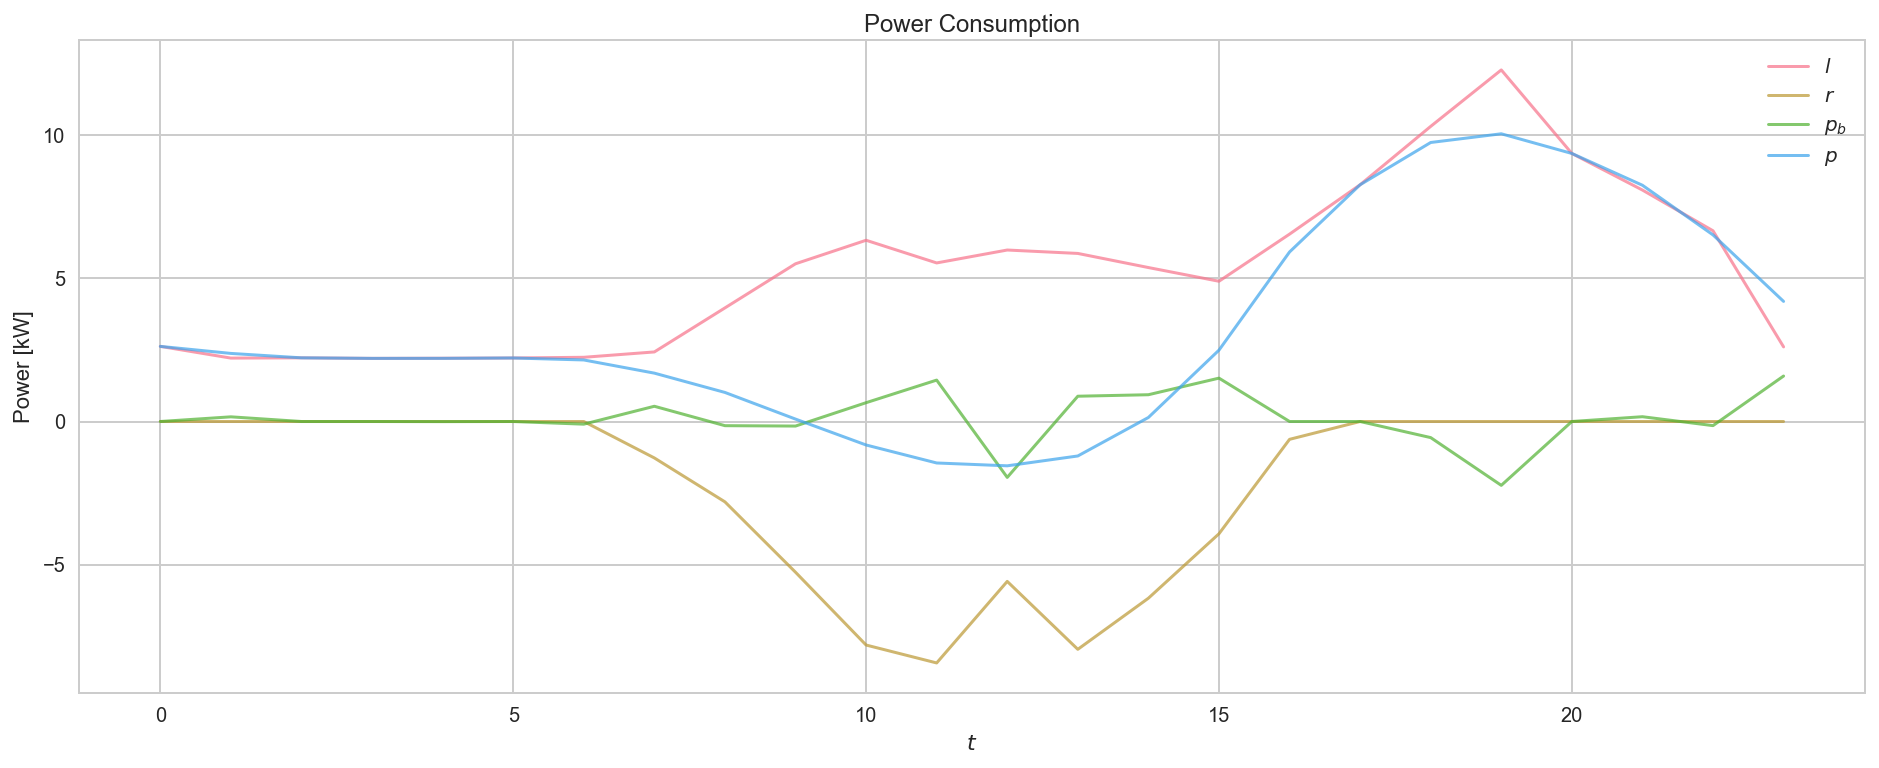

In [28]:
clf()
seaborn.set_style("whitegrid")

plot(l * mp.base_power * 1e3, label="$l$", color=seaborn.color_palette("husl")[0],alpha=0.7, lw=1.5)
#plot(p_g, label="$p_g$")
plot(r * mp.base_power * 1e3, label="$r$", color=seaborn.color_palette("husl")[1], alpha=0.7, lw=1.5)
plot(p_b * mp.base_power * 1e3, label="$p_b$", color=seaborn.color_palette("husl")[2], alpha=0.7,lw=1.5)
plot(p_net * mp.base_power * 1e3, label="$p$", color=seaborn.color_palette("husl")[4],alpha=0.7,lw=1.5)
title("Power Consumption")
xlabel("$t$")
ylabel("Power [kW]")

legend()
show()

Energy Cost $f(x^*) =$ {{"{:.3}".format(energy_cost_obj.value * cost_scaling_factor)}}

Load profile penalty $\nu (x^*)= $ {{"{:.3}".format(profile_smothing_obj.value)}}

## Lower Load Profile Penalty $\gamma = 0.5$

In [29]:
gamma = 5e-1

In [30]:
objective = cvxpy.Minimize(gamma * profile_smothing_obj + energy_cost_obj)
problem_2 = cvxpy.Problem(objective, constraints)
_ = problem_2.solve()

Energy Cost $f(x^*) =$ {{"{:.3}".format(energy_cost_obj.value * cost_scaling_factor)}}

Load profile penalty $\nu (x^*)= $ {{"{:.3}".format(profile_smothing_obj.value)}}

### Map Solution

Save (centralized) solution as $x^*$ and update model

In [31]:
xstar = np.array(x.value).flatten()
mp.set_var_values(np.array(x.value).flatten())
mp.update_properties()

###  Results

$p_b (t)$: power injected by the batteries

In [32]:
p_b  = np.fromiter([sum(bat.P for bat in net.batteries) for t, net in mp.networks.items()], np.float)

$l (t)$: power consumer by the loads

In [33]:
l  = np.fromiter([sum(load.P for load in net.loads) for t, net in mp.networks.items()], np.float)

$p_g (t)$: power injected by the (non-slack) generators

In [34]:
p_g = np.fromiter([sum(- gen.P for gen in net.generators) for t, net in mp.networks.items()], np.float)

$r (t)$: power injected by the renewable generation

In [35]:
r  = np.fromiter([sum(- gen.P for gen in net.var_generators) for t, net in mp.networks.items()], np.float)

$p (t)$: net power injection

In [36]:
p_net  = np.fromiter([l[t] + r[t] + p_g[t] + p_b[t]  for t in range(mp.timesteps)], np.float)

$\delta p  = p(t) - p(t-1)$: change in net power injection

In [37]:
dp_net = np.fromiter([p_net[t] - p_net[t-1] for t in range(mp.timesteps)], np.float)

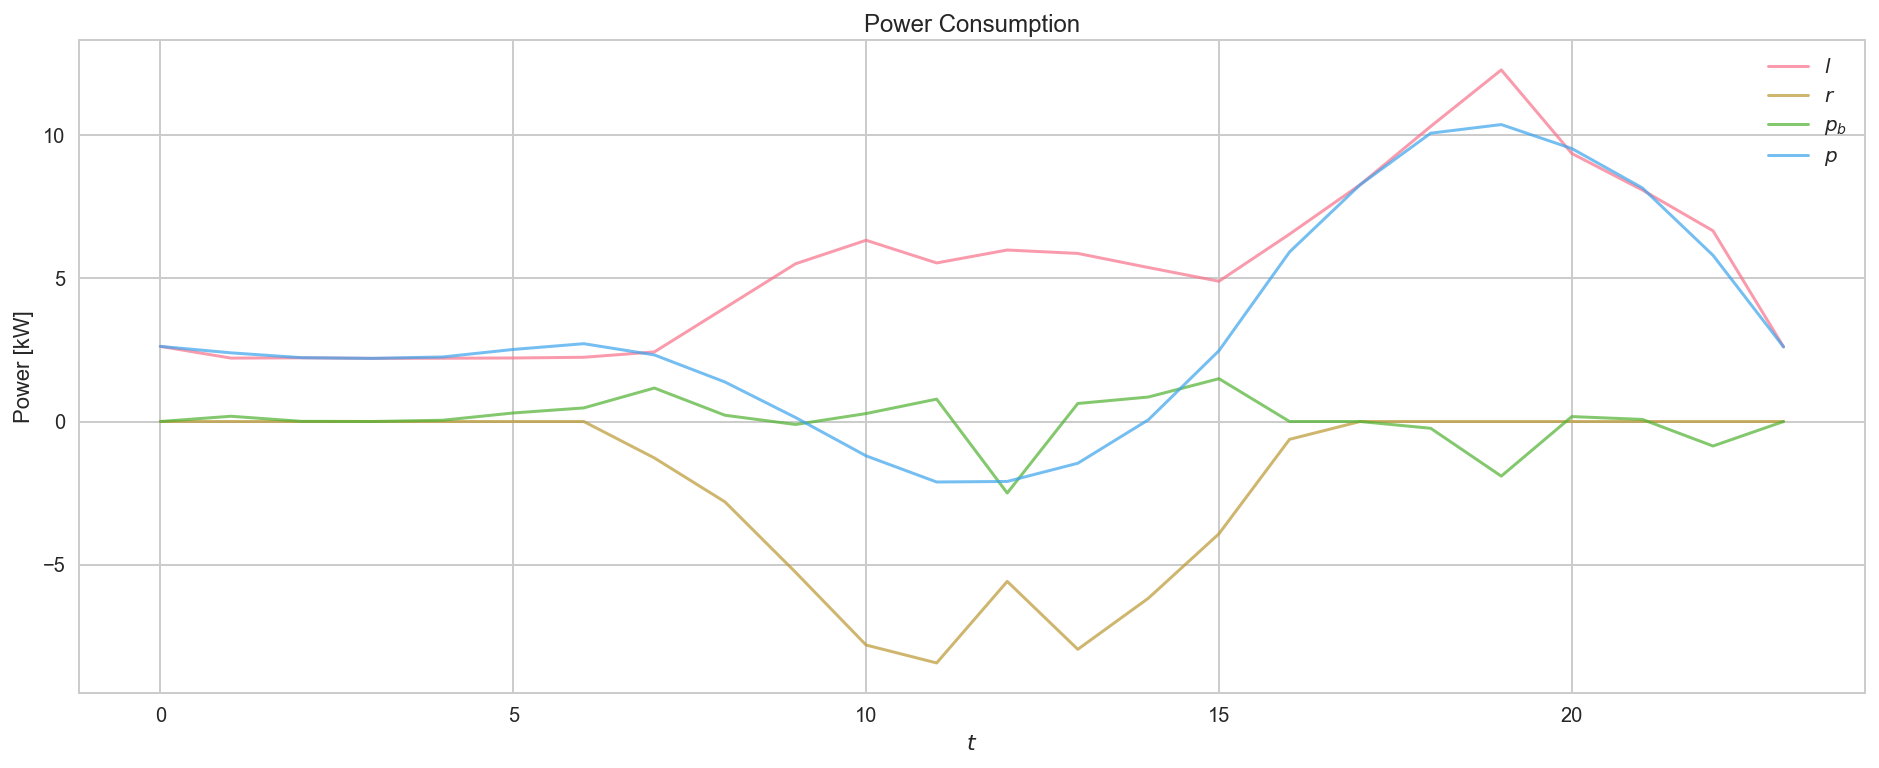

In [38]:
clf()
seaborn.set_style("whitegrid")

plot(l * mp.base_power * 1e3, label="$l$", color=seaborn.color_palette("husl")[0],alpha=0.7, lw=1.5)
#plot(p_g, label="$p_g$")
plot(r * mp.base_power * 1e3, label="$r$", color=seaborn.color_palette("husl")[1], alpha=0.7, lw=1.5)
plot(p_b * mp.base_power * 1e3, label="$p_b$", color=seaborn.color_palette("husl")[2], alpha=0.7,lw=1.5)
plot(p_net * mp.base_power * 1e3, label="$p$", color=seaborn.color_palette("husl")[4],alpha=0.7,lw=1.5)
#plot(dp_net, label="$\delta p$ ")
title("Power Consumption")
xlabel("$t$")
ylabel("Power [kW]")

legend()
show()

#### Energy Price

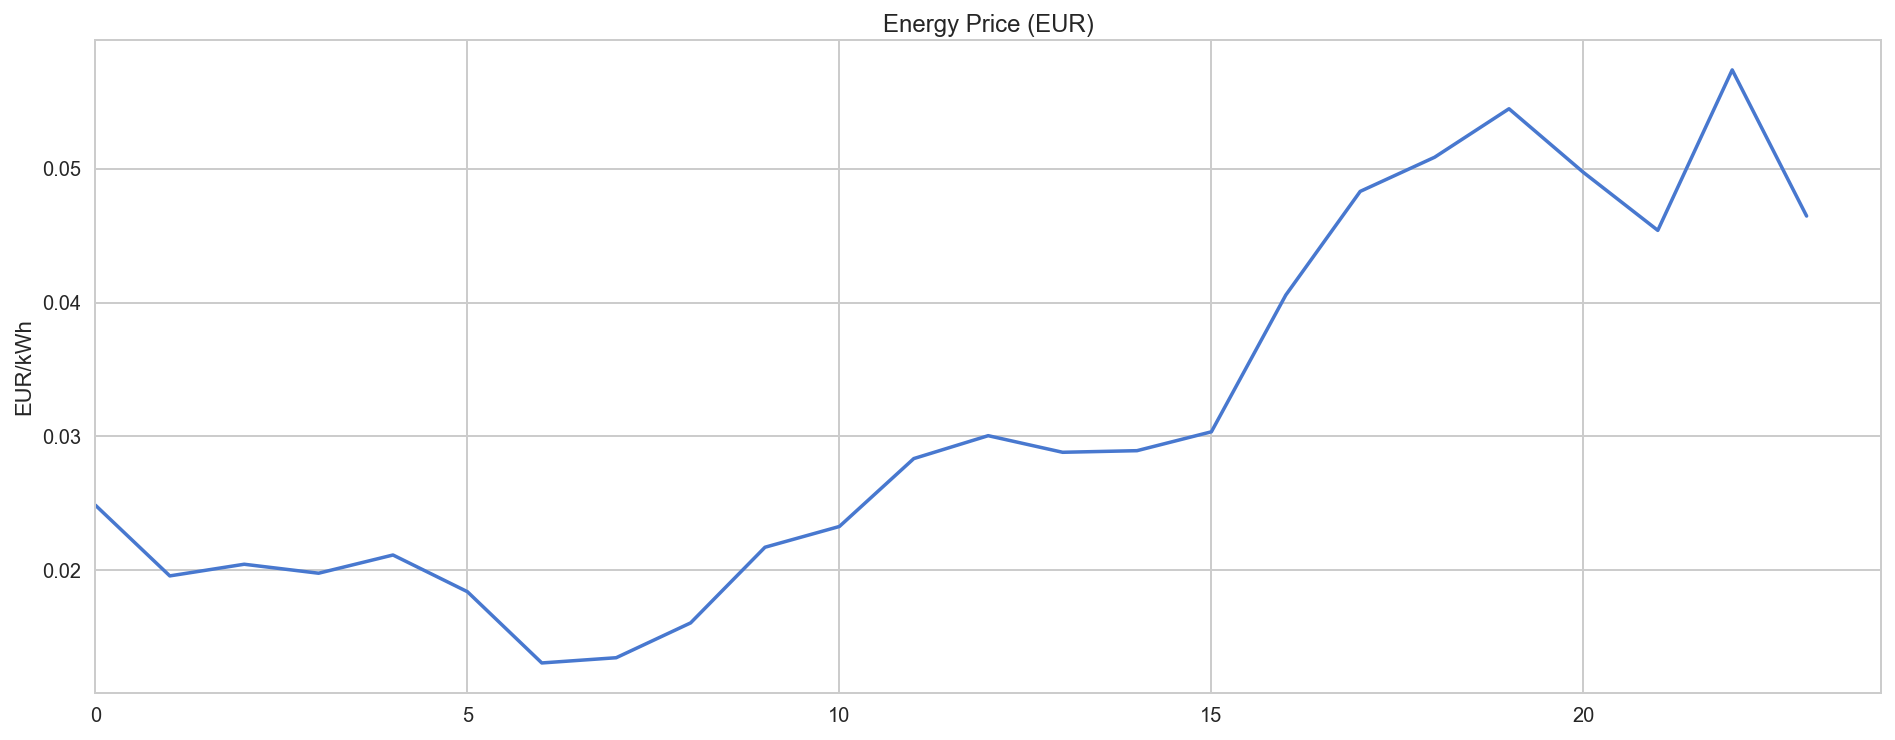

In [39]:
pfvis.plot_energy_price(mp)

# Plots

## Load Profile

In [40]:
%aimport pfvis
%aimport ipyplots

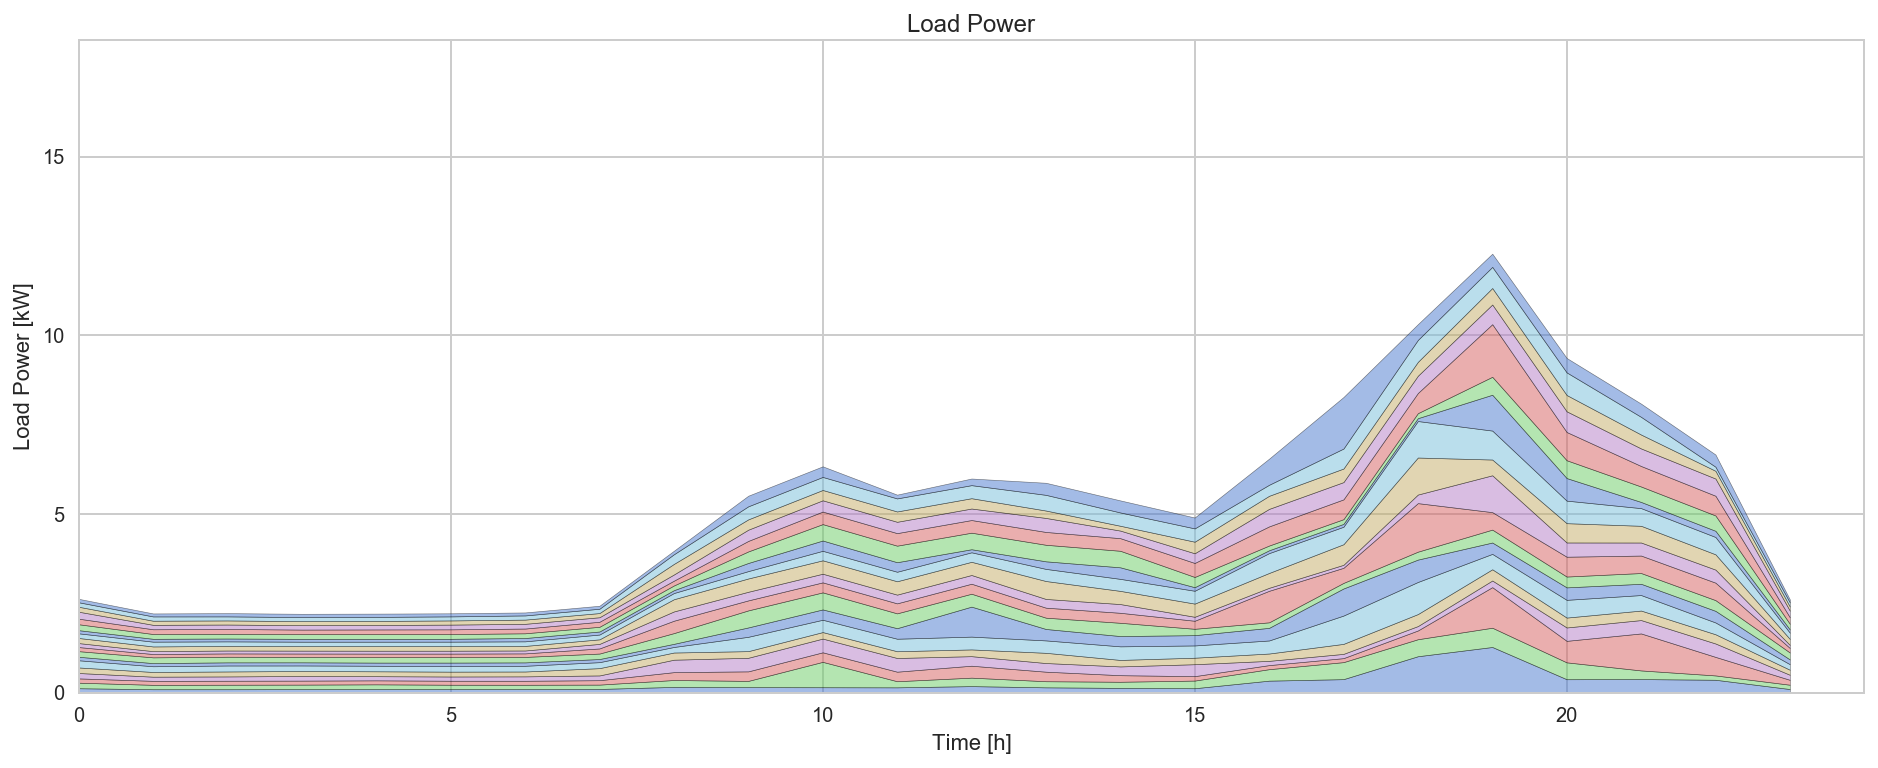

In [41]:
pfvis.plot_load_power(mp)

## Battery

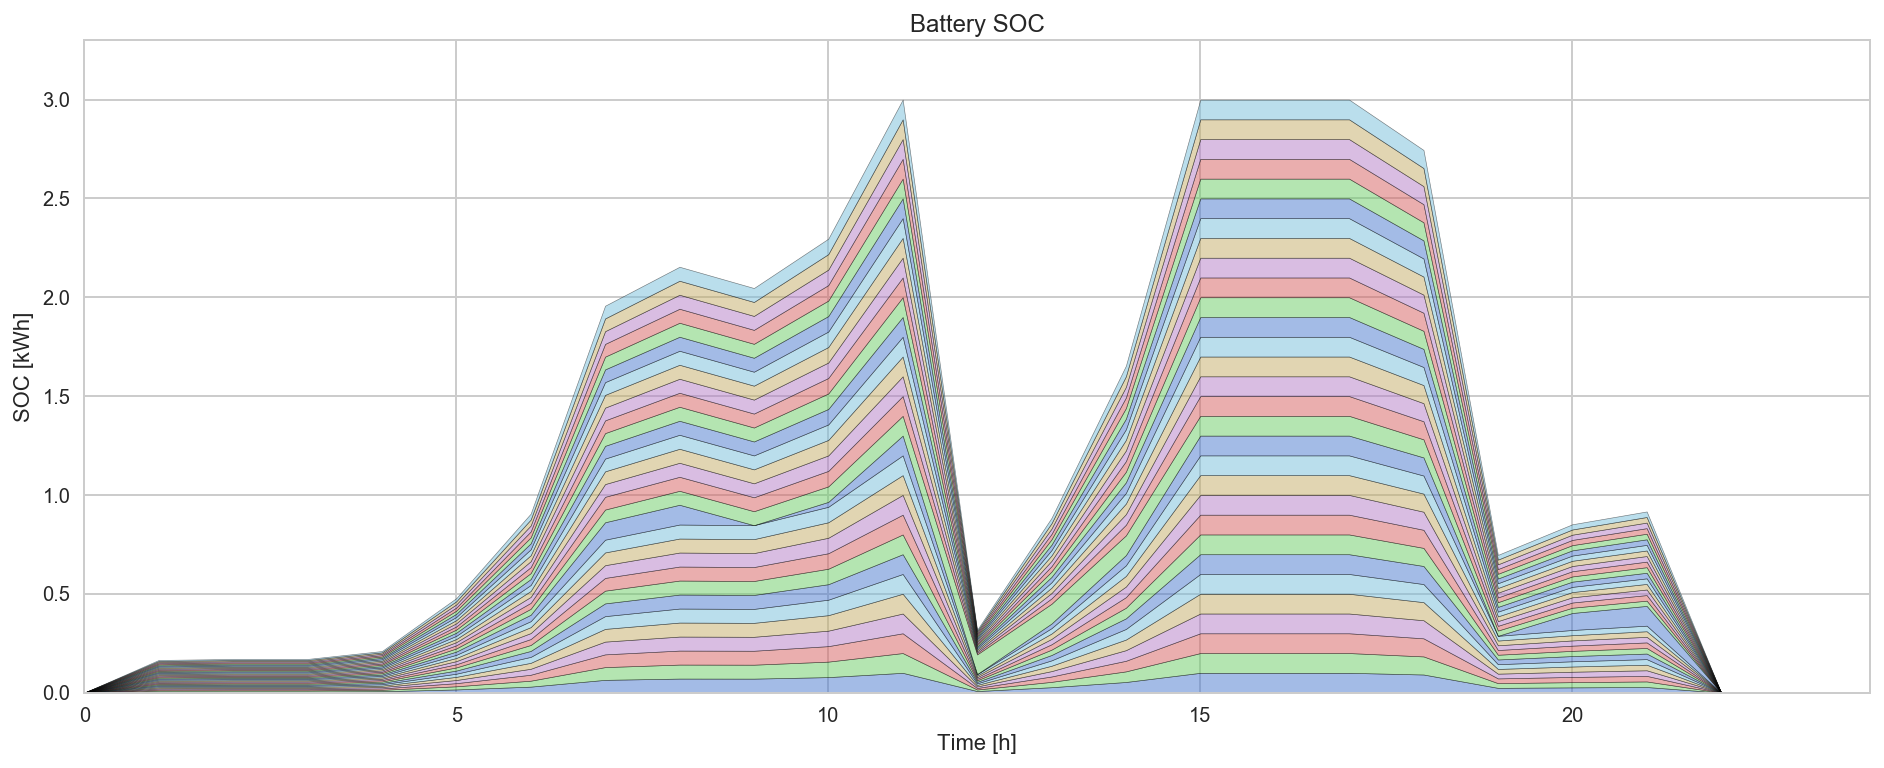

In [42]:
pfvis.plot_battery_soc(mp)

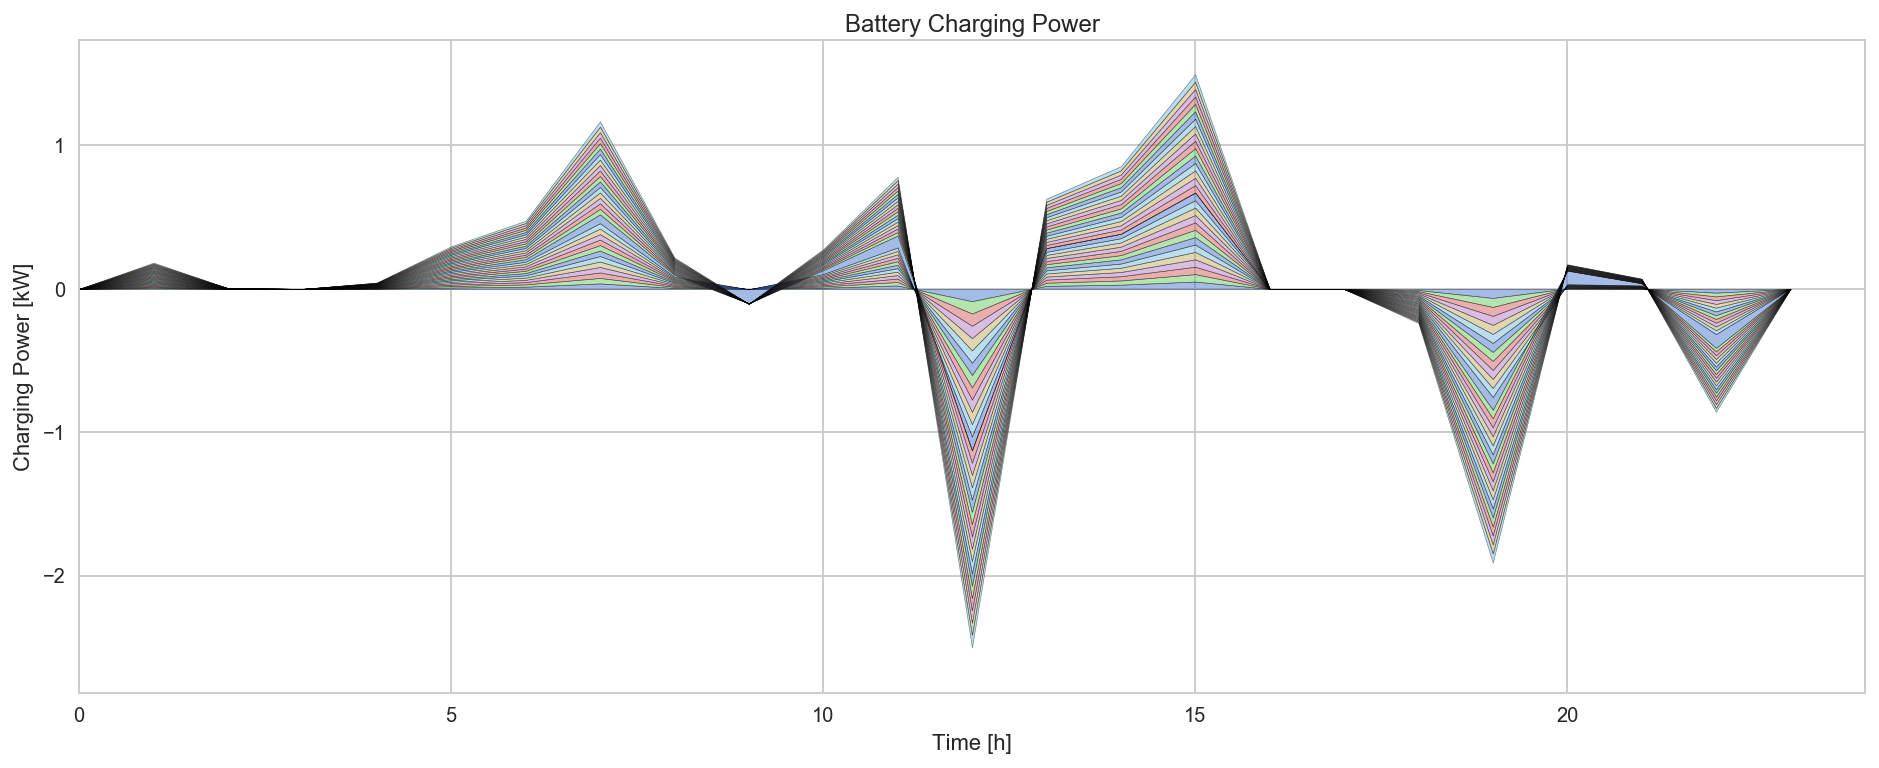

In [43]:
pfvis.plot_battery_power(mp)

## Renewable Power

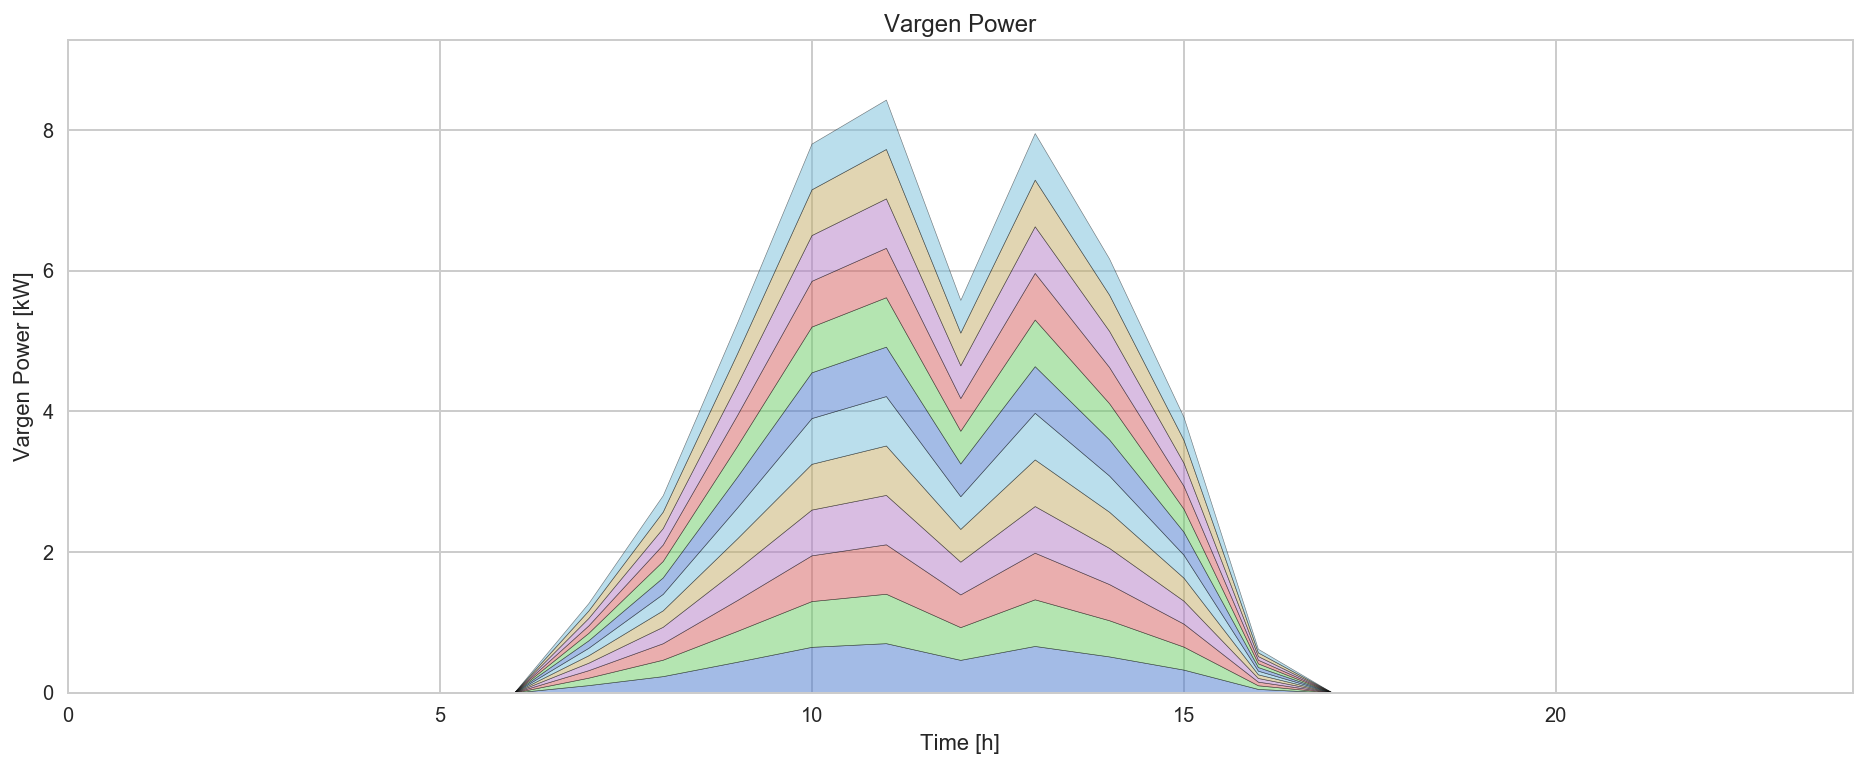

In [44]:
pfvis.plot_vargen_injection(mp)

# Split Problem Into Subproblem

Construct Projection Matrices

In [45]:
p_bats = {bus.index : mp.get_battery_var_projection(bus) for bus in filter(lambda bus: (not bus.is_slack()), mp.get_network().buses)}

Construct battery constraints for the individual buses

In [46]:
net = mp.get_network()
a_bats = dict()

for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
    if bus.bats:
        a_bats[bus.index] = scipy.sparse.vstack([p.get_battery_A(bat) * p_bats[bus.index].T for bat in bus.bats])
    else:
        a_bats[bus.index] = scipy.sparse.coo_matrix(([], ([], [])), shape=(0, p_bats[bus.index].T.shape[1]))
b_bats = dict()
for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
    if bus.bats:
        b_bats[bus.index] = np.hstack([p.get_battery_b(bat) for bat in bus.bats])   
    else:
        b_bats[bus.index] = np.array([])  

Construct linear bounds for the individual buses

In [47]:
l_mats = {bus.index: p_bats[bus.index] * p.l for bus in filter(lambda bus: (not bus.is_slack()), net.buses)}
u_mats = {bus.index: p_bats[bus.index] * p.u for bus in filter(lambda bus: (not bus.is_slack()), net.buses)}

Construct (seperable) energy cost functions

In [48]:
g_mats = {bus.index: p_bats[bus.index] * g for bus in filter(lambda bus: (not bus.is_slack()), net.buses)}

# CVXPY Distributed Problem

Construct (seperable subproblems $0, \ldots, n$)

In [49]:
dist_problems = dict()
local_energy_cost_obj = np.zeros(mp.get_network().num_buses, dtype='object')
local_objective = np.zeros(mp.get_network().num_buses, dtype='object')
local_constraints = dict()

for bus in filter(lambda bus: (not bus.is_slack()), mp.get_network().buses):
    i = bus.index
    num_var = g_mats[i].shape[0]
    x_i = p_bats[i] * x
    # check that x_i has the right dimensions
    assert(x_i.size[0] == num_var)
    
    # local constraints
    local_constraints[i] = [l_mats[i] <= x_i, x_i <= u_mats[i], a_bats[i] * x_i == b_bats[i]]
    
    # local objective
    local_energy_cost_obj[i] = g_mats[i].T * x_i 
    local_objective[i] = cvxpy.Minimize( local_energy_cost_obj[i])
    
    dist_problems[i] = cvxpy.Problem(local_objective[i], local_constraints[i])

Create problem with non-seperable objective (the load profile penalty)

In [50]:
non_seperable = cvxpy.Problem(cvxpy.Minimize(gamma * profile_smothing_obj))

Solve sum of problems

In [51]:
prob = (sum([prob for prob in dist_problems.values()]) + non_seperable)
prob.solve()
pstar = prob.objective.value

# Distributed Projected Gradient Descent

Check if there exists a $t \in \{0, \ldots, T \}$ s.t. $P_{c, i} (t) > 0 \land P_{d, i} (t) > 0$ 

In [169]:
D_s = scipy.vstack([np.array([0, 0, 0] * t + [1, -1, 0, -1, 1, 0] + [0, 0, 0] * (mp.timesteps - t - 2), ndmin=2) for t in range(mp.timesteps - 1)])

In [170]:
D_c = scipy.vstack([np.array([0] * t + [1, -1] + [0] * (mp.timesteps - t - 2), ndmin=2) for t in range(mp.timesteps - 1)])

Constant Power: $$c_i = \left( l_i (0) - r_i (0), \ldots, l_i (T) - r_i (T) \right)$$

In [54]:
c = dict()
for bus_i in filter(lambda bus: (not bus.is_slack()), mp.get_network().buses):
    i = bus_i.index
    c[i] = np.matrix(np.fromiter((constant_powers[t, i] for t in range(mp.timesteps)), dtype=float)).T

$$d_c = \sum_{i \in \Omega_b} D_c c_i$$

In [171]:
d_c = sum([D_c * c[bus.index] for bus in filter(lambda bus: (not bus.is_slack()), mp.get_network().buses)]).A.flatten()

$$d_s (x) = \sum_{i \in \Omega_b} D_s P_{b, i} x$$
with $\Omega_b$ is the set of buses excluding the slack bus and $P_{b,i}$ the projection variable extracting the variables related to bus $i$.

In [172]:
def d_s(x):
    return sum([D_s.dot(p_bats[bus.index] * x) for bus in filter(lambda bus: (not bus.is_slack()), mp.get_network().buses)])

Cost function $$h(x) = \gamma (d_c^\top d_c + 2 d_c^\top d_s (x) + d_s (x)^\top d_s (x)) + g^\top x$$

In [57]:
def h(x):
    return gamma * (np.dot(d_c,d_c) + 2 * np.dot(d_c, d_s(x)) + np.dot(d_s(x), d_s(x))) + (np.dot(g, x))

Gradient of $h(x)$ at bus $i$
$$ \nabla h_i (x) = \gamma ( 2 d_c^\top D + 2 d_s(x)^\top D) + P_{b, i} g \\
= 2 \gamma ( d_c + d_s(x))^\top D  + P_{b, i} g$$

In [58]:
def grad_h(x, bus=None):
    if bus is not None:
        return gamma* (2 * d_c.dot(D) + 2 * d_s(x).dot(D)) + p_bats[bus.index] * g
    else:
        return gamma* sum([p_bat.T * (2 * d_c.dot(D) + 2 * d_s(x).dot(D)) for p_bat in p_bats.values()]) + g

## Check Gradient

In [59]:
a_1 = scipy.optimize.approx_fprime(xstar, h, 1e-8)

Relative Error of the gradient in percent

In [60]:
rel_grad_err = np.max(100 * np.abs(a_1 - grad_h(xstar)) / np.maximum(np.abs(grad_h(xstar)), 1e-5))

Relative Gradient Error: $100 \cdot \frac{\max{|a_1 - \Delta h (x^*)|}}{\max{(|\Delta h (x^*)|, 10^{-5}})} = $  {{"{:.3}".format(rel_grad_err)}}

## Projection Step

In [61]:
def proj_x(xbar, i):
    
    # Solve with OPTALG
    
    #prob = optalg.opt_solver.QuadProblem(scipy.sparse.eye(len(xbar)), -xbar, a_bats[i], b_bats[i], l_mats[i], u_mats[i], x=xbar)    
    #solver =optalg.opt_solver.OptSolverIQP()
    #solver.set_parameters({'quiet' : True, 'tol' : 1e-4})    
    #solver.solve(prob)

    #return solver.get_primal_variables()
    
    # Solve with CVXPY (ECOS)
    x_s = cvxpy.Variable(len(xbar))
    proj_obj = cvxpy.Minimize(cvxpy.norm(xbar - x_s))
    proj_constr = [l_mats[i] <= x_s, x_s <= u_mats[i], a_bats[i] * x_s == b_bats[i]]
    proj_prob = cvxpy.Problem(proj_obj, proj_constr)
    proj_prob.solve()
    return x_s.value.A.flatten()

In [62]:
def global_proj_x(xbar):
    x_s = cvxpy.Variable(len(xbar))
    x_s.value = xbar
    proj_obj = cvxpy.Minimize(cvxpy.norm(xbar - x_s))
    proj_constr = [p.l <= x_s, x_s <= p.u, p.A * x_s == p.b]
    proj_prob = cvxpy.Problem(proj_obj, proj_constr)
    proj_prob.solve(solver=cvxpy.ECOS, max_iters=10000)
    return x_s.value.A.flatten()
    
    #prob = optalg.opt_solver.QuadProblem(scipy.sparse.eye(len(xbar)), -xbar, p.A, p.b, p.l, p.u, x=xbar)
    #solver =optalg.opt_solver.OptSolverIQP()
    #solver.set_parameters({'quiet' : True, 'tol' : 1e-8})    
    #solver.solve(prob)
    #return solver.get_primal_variables()

## Solve

In [63]:
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats=['retina']

it 	 obj 	 	 err 	 	 ||d h|| 	  alpha


/usr/local/lib/python3.5/site-packages/matplotlib-0+unknown-py3.5-macosx-10.11-x86_64.egg/matplotlib/__init__.py:923: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


0 	 4.10E-01 	 2.23E-01 	 9.77E-01 	 4.00E-03 	 1.49E-03
10 	 2.49E-01 	 6.18E-02 	 7.45E-01 	 4.00E-03 	 4.59E-04
20 	 2.05E-01 	 1.75E-02 	 6.84E-01 	 4.00E-03 	 2.53E-04
30 	 1.94E-01 	 7.32E-03 	 6.66E-01 	 4.00E-03 	 1.68E-04
40 	 1.91E-01 	 3.82E-03 	 6.71E-01 	 4.00E-03 	 5.66E-05
50 	 1.90E-01 	 3.06E-03 	 6.71E-01 	 4.00E-03 	 4.27E-05
60 	 1.90E-01 	 2.59E-03 	 6.68E-01 	 4.00E-03 	 4.16E-05
70 	 1.89E-01 	 2.25E-03 	 6.66E-01 	 4.00E-03 	 3.91E-05
80 	 1.89E-01 	 1.99E-03 	 6.64E-01 	 4.00E-03 	 4.13E-05
90 	 1.89E-01 	 1.77E-03 	 6.62E-01 	 4.00E-03 	 4.03E-05
100 	 1.89E-01 	 1.60E-03 	 6.61E-01 	 4.00E-03 	 3.94E-05
110 	 1.89E-01 	 1.45E-03 	 6.60E-01 	 4.00E-03 	 3.88E-05
120 	 1.88E-01 	 1.32E-03 	 6.59E-01 	 4.00E-03 	 3.84E-05
130 	 1.88E-01 	 1.20E-03 	 6.59E-01 	 4.00E-03 	 3.81E-05
140 	 1.88E-01 	 1.10E-03 	 6.59E-01 	 4.00E-03 	 3.79E-05
150 	 1.88E-01 	 1.01E-03 	 6.58E-01 	 4.00E-03 	 3.77E-05
160 	 1.88E-01 	 9.17E-04 	 6.58E-01 	 4.00E-03 	 3.75E-05
170 	 1.

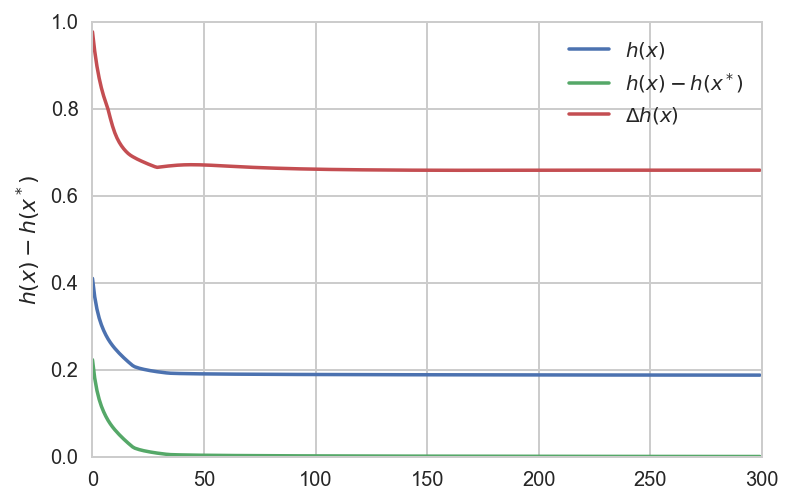

In [64]:
xsol = global_proj_x(np.zeros((len(xstar),)))
buses_wo_slack = list(filter(lambda bus: (not bus.is_slack()), mp.get_network().buses))

max_iteration = 300
objective_values = []
error_values = []
dh_values = []

fig, ax = plt.subplots(1,1)
fig.canvas.set_window_title("Distributed Primal Gradient")

colors = seaborn.color_palette()
ax.plot(objective_values, label="$h(x)$", color=colors[0])
ax.plot(error_values, label="$h(x) - h(x^*)$", color=colors[1])
ax.plot(dh_values, label="$\Delta h (x)$", color=colors[2])
legend()
ylabel('$h(x) - h(x^*)$')
ax.set_xlim(0, max_iteration)    
ax.set_ylim(0,1) 
fig.canvas.draw()

print("it \t obj \t \t err \t \t ||d h|| \t  alpha")


for iteration in range(max_iteration):
    alpha = 4e-3 #/ (iteration/4 + 1)
    
    xstep = np.zeros(xsol.shape)
    
    with multiprocessing.Pool() as pool:
        steps = pool.starmap(proj_x, [(p_bats[bus.index] * xsol - alpha * grad_h(xsol, bus=bus), bus.index) for bus in buses_wo_slack])

    for i, step in enumerate(steps):
        xstep += p_bats[i].T * step

    xpre = xsol.copy()
    xsol = xstep
    
    error_to_centralized =  h(xsol)  - h(xstar)
    
    # Output
    objective_values.append(h(xsol))
    error_values.append(error_to_centralized)
    dh_values.append(norm(grad_h(xsol), ord=inf))
    plot_x = np.arange(0, iteration+1)
    ax.lines[0].set_xdata(plot_x)
    ax.lines[0].set_ydata(objective_values)
    ax.lines[1].set_xdata(plot_x)    
    ax.lines[1].set_ydata(error_values)
    ax.lines[2].set_xdata(plot_x)    
    ax.lines[2].set_ydata(dh_values)
    fig.canvas.draw()
    
    # check convergence
    if norm(xsol - xpre, ord=inf) < 1e-5:
        print('Converged')
        break
    if iteration % 10 == 0:
        print("{} \t {:.2E} \t {:.2E} \t {:.2E} \t {:.2E} \t {:.2E}".format(iteration, h(xsol), error_to_centralized, norm(grad_h(xsol), ord=inf),  alpha, norm(xsol - xpre, ord=inf)))

fig.canvas.draw()
show()

In [65]:
psol = h(xsol)

Difference in objective value compared to CVXPY

## Map Results

In [66]:
mp.set_var_values(xsol)
mp.update_properties()

## Show Results

$p_b (t)$: power injected by the batteries

In [67]:
p_b  = np.fromiter([sum(bat.P for bat in net.batteries) for t, net in mp.networks.items()], np.float)

$l (t)$: power consumer by the loads

In [68]:
l  = np.fromiter([sum(load.P for load in net.loads) for t, net in mp.networks.items()], np.float)

$p_g (t)$: power injected by the (non-slack) generators

In [69]:
p_g = np.fromiter([sum(- gen.P for gen in net.generators) for t, net in mp.networks.items()], np.float)

$r (t)$: power injected by the renewable generation

In [70]:
r  = np.fromiter([sum(- gen.P for gen in net.var_generators) for t, net in mp.networks.items()], np.float)

$p (t)$: net power injection

In [71]:
p_net  = np.fromiter([l[t] + r[t] + p_g[t] + p_b[t]  for t in range(mp.timesteps -1)], np.float)

$\delta p  = p(t) - p(t-1)$: change in net power injection

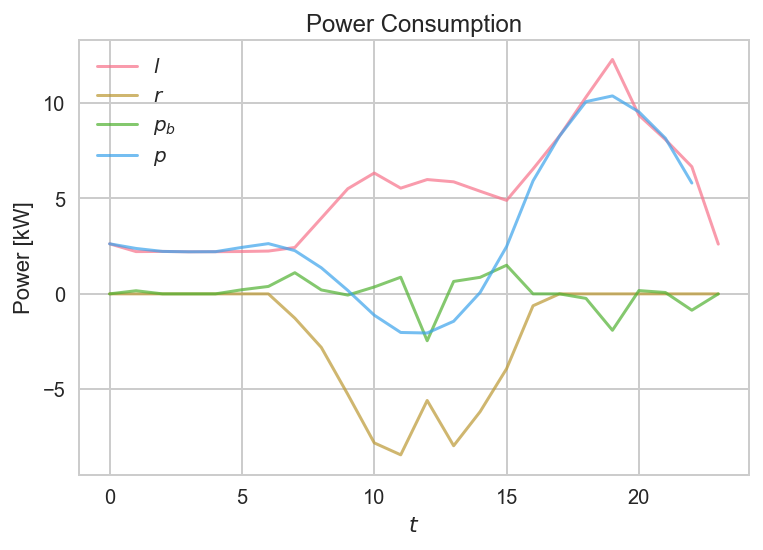

In [72]:
fig, ax = plt.subplots(1,1)

seaborn.set_style("whitegrid")

ax.plot(l * mp.base_power * 1e3, label="$l$", color=seaborn.color_palette("husl")[0],alpha=0.7, lw=1.5)
#plot(p_g, label="$p_g$")
ax.plot(r * mp.base_power * 1e3, label="$r$", color=seaborn.color_palette("husl")[1], alpha=0.7, lw=1.5)
ax.plot(p_b * mp.base_power * 1e3, label="$p_b$", color=seaborn.color_palette("husl")[2], alpha=0.7,lw=1.5)
ax.plot(p_net * mp.base_power * 1e3, label="$p$", color=seaborn.color_palette("husl")[4],alpha=0.7,lw=1.5)
title("Power Consumption")
xlabel("$t$")
ylabel("Power [kW]")

legend()
fig.canvas.draw()


In [73]:
print("{:.2E}".format(h(xsol)))

1.87E-01


# FOBOS

Cost function $f(x)$(the load profile smoothing term)

In [74]:
def f(x):
    return gamma * (np.dot(d_c,d_c) + 2 * np.dot(d_c, d_s(x)) + np.dot(d_s(x), d_s(x)))

Gradient of $f(x)$ (the load profile smoothing term)

In [75]:
def grad_f(x, bus=None):
    if bus is not None:
        return gamma* (2 * d_c.dot(D) + 2 * d_s(x).dot(D))
    else:
        return gamma* sum([p_bat.T * (2 * d_c.dot(D) + 2 * d_s(x).dot(D)) for p_bat in p_bats.values()])

proximal operator

$$ \text{argmin} \frac 1 2 \left||{x - \bar x}\right||^2_2 + \eta g^\top x$$
s.t. $$A x = b \\ l \le x \le u$$


$$\text{prox}_r (x)$$
with
$$ r(x) = \eta g^\top x $$
$$\mathrm{dom}(r(x)) = \left\{ x | A x  = b, l \le x \le u \right\}$$

In [76]:
def prox_step(xbar, i, alpha):
    eta = alpha
    x_s = cvxpy.Variable(len(xbar))
    proj_obj = cvxpy.Minimize(0.5 * cvxpy.sum_squares(x_s - xbar) + eta * g_mats[i] * x_s)
    proj_constr = [l_mats[i] <= x_s, x_s <= u_mats[i], a_bats[i] * x_s == b_bats[i]]
    proj_prob = cvxpy.Problem(proj_obj, proj_constr)
    proj_prob.solve()
    return x_s.value.A.flatten()

$$x^{k+1} = \text{prox}_r (x^{k} - \alpha \Delta f)$$

it 	 obj 	 	 err 	 	 ||d f|| 	  alpha 	 $$\delta x$$


/usr/local/lib/python3.5/site-packages/matplotlib-0+unknown-py3.5-macosx-10.11-x86_64.egg/matplotlib/__init__.py:923: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


0 	 1.63E+00 	 1.45E+00 	 1.28E+00 	 1.00E+00 	 2.37E-02
10 	 3.45E+00 	 3.26E+00 	 1.51E+00 	 1.00E-01 	 2.42E-02
20 	 3.10E+00 	 2.91E+00 	 1.46E+00 	 5.00E-02 	 1.62E-02
30 	 3.53E+00 	 3.34E+00 	 1.53E+00 	 3.33E-02 	 1.37E-02
40 	 3.79E+00 	 3.61E+00 	 1.56E+00 	 2.50E-02 	 1.25E-02
50 	 3.60E+00 	 3.41E+00 	 1.56E+00 	 2.00E-02 	 1.17E-02
60 	 3.35E+00 	 3.16E+00 	 1.56E+00 	 1.67E-02 	 1.11E-02
70 	 2.85E+00 	 2.66E+00 	 1.52E+00 	 1.43E-02 	 1.11E-02
80 	 1.72E+00 	 1.53E+00 	 1.35E+00 	 1.25E-02 	 1.04E-02
90 	 3.19E-01 	 1.32E-01 	 6.59E-01 	 1.11E-02 	 2.85E-03
100 	 2.25E-01 	 3.75E-02 	 6.58E-01 	 1.00E-02 	 2.49E-04
110 	 2.14E-01 	 2.67E-02 	 6.59E-01 	 9.09E-03 	 1.95E-04
120 	 2.10E-01 	 2.27E-02 	 6.59E-01 	 8.33E-03 	 1.77E-04
130 	 2.06E-01 	 1.92E-02 	 6.59E-01 	 7.69E-03 	 1.62E-04
140 	 2.03E-01 	 1.61E-02 	 6.59E-01 	 7.14E-03 	 1.41E-04
150 	 2.00E-01 	 1.32E-02 	 6.59E-01 	 6.67E-03 	 1.33E-04
160 	 1.98E-01 	 1.05E-02 	 6.59E-01 	 6.25E-03 	 1.29E-04
170 	 1.

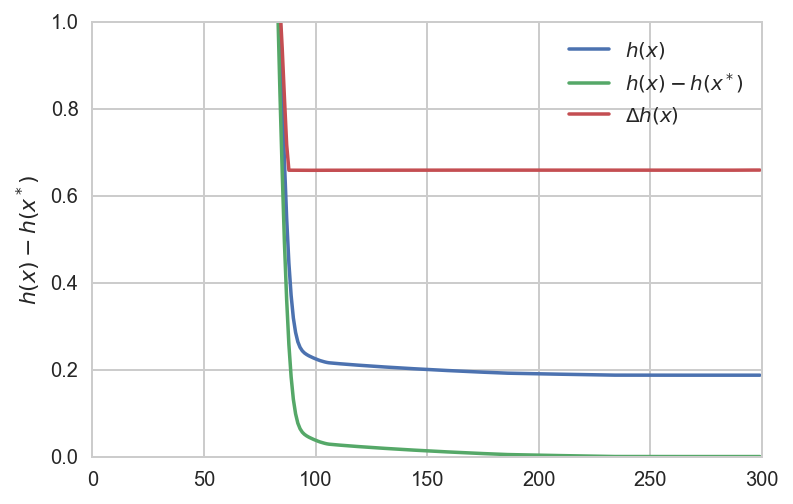

In [77]:
# initialize with a valid starting point
xsol = global_proj_x(np.zeros((len(xstar),)))
buses_wo_slack = list(filter(lambda bus: (not bus.is_slack()), mp.get_network().buses))

max_iteration = 300

# save convergence values
objective_values = []
error_values = []
dh_values = []

# show convergence plot
colors = seaborn.color_palette()
fig, ax = plt.subplots(1,1)
fig.canvas.set_window_title("FOBOS")
ax.plot(objective_values, label="$h(x)$", color=colors[0])
ax.plot(error_values, label="$h(x) - h(x^*)$", color=colors[1])
ax.plot(dh_values, label="$\Delta h (x)$", color=colors[2])
legend()
ylabel('$h(x) - h(x^*)$')
ax.set_xlim(0, max_iteration)    
ax.set_ylim(0,1) 
fig.canvas.draw()

print("it \t obj \t \t err \t \t ||d f|| \t  alpha \t $$\delta x$$")


for iteration in range(max_iteration):
    alpha = 1/np.maximum(iteration,1)

    xstep = np.zeros(xsol.shape)
    with multiprocessing.Pool() as pool:
        steps = pool.starmap(prox_step, [(p_bats[bus.index] * xsol - alpha * grad_f(xsol, bus=bus), bus.index, alpha) for bus in buses_wo_slack])

    for i, step in enumerate(steps):
        xstep += p_bats[i].T * step

    xpre = xsol.copy()
    xsol = xstep
    
    error_to_centralized =  h(xsol)  - h(xstar)
    
    # Output
    objective_values.append(h(xsol))
    error_values.append(error_to_centralized)
    dh_values.append(norm(grad_h(xsol), ord=inf))
    
    # Set plot data
    ax.lines[0].set_xdata(np.arange(0, iteration+1))
    ax.lines[0].set_ydata(objective_values)
    ax.lines[1].set_xdata(np.arange(0, iteration+1))    
    ax.lines[1].set_ydata(error_values)
    ax.lines[2].set_xdata(np.arange(0, iteration+1))    
    ax.lines[2].set_ydata(dh_values)
    fig.canvas.draw()
    
    if iteration % 10 == 0:
        print("{} \t {:.2E} \t {:.2E} \t {:.2E} \t {:.2E} \t {:.2E}".format(iteration, h(xsol), error_to_centralized, norm(grad_h(xsol), ord=inf),  alpha, norm(xsol - xpre, ord=inf)))

fig.canvas.draw()
show()

# Stochastic Proximal Gradient

it 	 obj 	 	 err 	 	 ||d f|| 	  alpha 	 dx


/usr/local/lib/python3.5/site-packages/matplotlib-0+unknown-py3.5-macosx-10.11-x86_64.egg/matplotlib/__init__.py:923: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


0 	 5.34E-01 	 3.46E-01 	 8.06E-01 	 1.00E+00 	 1.19E-02
10 	 7.11E-01 	 5.24E-01 	 8.60E-01 	 1.00E-01 	 5.13E-03
20 	 6.45E-01 	 4.58E-01 	 8.76E-01 	 5.00E-02 	 3.96E-03
30 	 5.41E-01 	 3.54E-01 	 8.23E-01 	 3.33E-02 	 3.70E-03
40 	 3.65E-01 	 1.78E-01 	 6.58E-01 	 2.50E-02 	 3.51E-03
50 	 2.13E-01 	 2.58E-02 	 6.59E-01 	 2.00E-02 	 3.81E-04
60 	 1.95E-01 	 8.35E-03 	 6.59E-01 	 1.67E-02 	 1.67E-04
70 	 1.88E-01 	 1.15E-03 	 6.59E-01 	 1.43E-02 	 1.09E-04
80 	 1.88E-01 	 6.72E-04 	 6.59E-01 	 1.25E-02 	 9.73E-05
90 	 1.88E-01 	 4.81E-04 	 6.59E-01 	 1.11E-02 	 5.17E-05
100 	 1.87E-01 	 3.61E-04 	 6.59E-01 	 1.00E-02 	 4.65E-05
110 	 1.87E-01 	 3.03E-04 	 6.59E-01 	 9.09E-03 	 4.24E-05
120 	 1.87E-01 	 2.64E-04 	 6.59E-01 	 8.33E-03 	 3.92E-05
130 	 1.87E-01 	 2.34E-04 	 6.59E-01 	 7.69E-03 	 3.59E-05
140 	 1.87E-01 	 2.13E-04 	 6.59E-01 	 7.14E-03 	 1.60E-05
150 	 1.87E-01 	 2.01E-04 	 6.59E-01 	 6.67E-03 	 1.49E-05
160 	 1.87E-01 	 1.91E-04 	 6.59E-01 	 6.25E-03 	 1.40E-05
170 	 1.

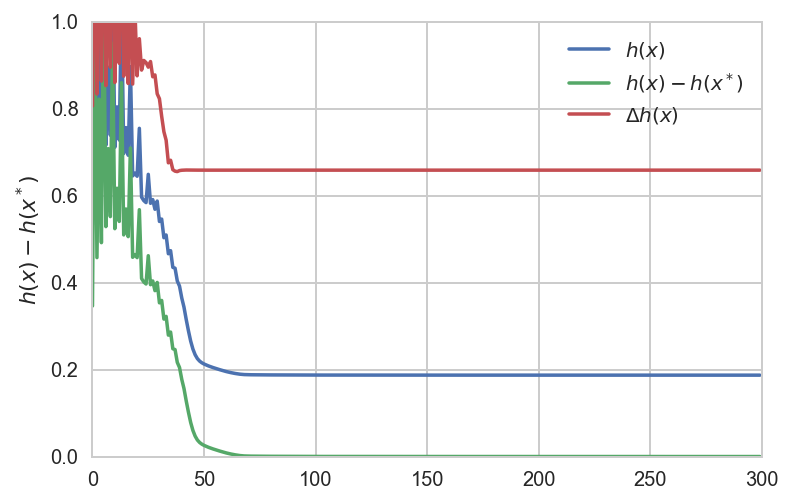

In [81]:
# initialize with a valid starting point
xsol = global_proj_x(np.zeros((len(xstar),)))
buses_wo_slack = list(filter(lambda bus: (not bus.is_slack()), mp.get_network().buses))

max_iteration = 300
ld = 0.5

# save convergence values
objective_values = []
error_values = []
dh_values = []

# show convergence plot
colors = seaborn.color_palette()
fig, ax = plt.subplots(1,1)
fig.canvas.set_window_title("Stochastic Proximal Gradient")
ax.plot(objective_values, label="$h(x)$", color=colors[0])
ax.plot(error_values, label="$h(x) - h(x^*)$", color=colors[1])
ax.plot(dh_values, label="$\Delta h (x)$", color=colors[2])
#ax.set_yscale('log')
legend()
ylabel('$h(x) - h(x^*)$')
ax.set_xlim(0, max_iteration)    
ax.set_ylim(0,1) 
fig.canvas.draw()

print("it \t obj \t \t err \t \t ||d f|| \t  alpha \t dx")


for iteration in range(max_iteration):
    alpha = 1/np.maximum(iteration,1)

    xstep = np.zeros(xsol.shape)
    with multiprocessing.Pool() as pool:
        steps = pool.starmap(prox_step, [(p_bats[bus.index] * xsol - alpha * grad_f(xsol, bus=bus), bus.index, alpha) for bus in buses_wo_slack])

    for i, step in enumerate(steps):
        xstep += p_bats[i].T * step

    xpre = xsol.copy()
    xsol = (1-ld) * xpre + ld * xstep
    
    error_to_centralized =  h(xsol)  - h(xstar)
    
    # Output
    objective_values.append(h(xsol))
    error_values.append(error_to_centralized)
    dh_values.append(norm(grad_h(xsol), ord=inf))
    
    # Set plot data
    ax.lines[0].set_xdata(np.arange(0, iteration+1))
    ax.lines[0].set_ydata(objective_values)
    ax.lines[1].set_xdata(np.arange(0, iteration+1))    
    ax.lines[1].set_ydata(error_values)
    ax.lines[2].set_xdata(np.arange(0, iteration+1))    
    ax.lines[2].set_ydata(dh_values)
    fig.canvas.draw()
    
    if iteration % 10 == 0:
        print("{} \t {:.2E} \t {:.2E} \t {:.2E} \t {:.2E} \t {:.2E}".format(iteration, h(xsol), error_to_centralized, norm(grad_h(xsol), ord=inf),  alpha, norm(xsol - xpre, ord=inf)))

fig.canvas.draw()
show()

# Noise

Laplacian Noise: $f(x; \mu, \lambda) = \frac{1}{2\lambda} \exp \left( - \frac{|x- \mu|}{\lambda} \right)$
 
Sensitivity: $\lambda = \frac{\Delta F}{\epsilon}$

$\mu = F(D)$

In [188]:
epsilon = 1e-2
delta_q = 1e-7

Nosiy Gradient of $h'(x)$ at bus $i$
$$ \Delta h'_i (x) = \gamma ( 2 d_c^\top D + 2 d_s(x)^\top D) + P_{b, i} g + w_k\\
= 2 \gamma ( d_c + d_s(x))^\top D  + P_{b, i} g + w_k$$

$$w_k = \exp \left( - \frac{2 \epsilon ||w_k||}{K (K-1) L \Delta} \right)$$

$\mu = 0$

$\lambda = \frac{K (K-1) L \Delta}{2 \epsilon || w_k||}$

In [189]:
def get_noisy_vector(k, shape):
    lamd = delta_q / epsilon
    if k == 0:
        noise = np.zeros(shape)
    else: 
        noise = np.random.laplace(loc=0, scale=lamd, size=shape)
    return noise

In [190]:
get_noisy_vector(1, (4, ))

array([  1.12259822e-05,  -6.44965138e-06,  -7.87484170e-07,
         3.69452632e-05])

it 	 obj 	 	 err 	 	 ||d f|| 	  alpha 	 dx


/usr/local/lib/python3.5/site-packages/matplotlib-0+unknown-py3.5-macosx-10.11-x86_64.egg/matplotlib/__init__.py:923: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


0 	 2.23E+00 	 2.05E+00 	 1.44E+00 	 1.00E+00 	 2.77E-02
10 	 9.04E-01 	 7.17E-01 	 8.10E-01 	 1.00E-01 	 5.15E-03
20 	 5.17E-01 	 3.30E-01 	 6.53E-01 	 5.00E-02 	 1.96E-03
30 	 4.24E-01 	 2.36E-01 	 6.56E-01 	 3.33E-02 	 1.72E-04
40 	 4.06E-01 	 2.19E-01 	 6.58E-01 	 2.50E-02 	 9.80E-05
50 	 3.96E-01 	 2.09E-01 	 6.59E-01 	 2.00E-02 	 6.32E-05
60 	 3.90E-01 	 2.03E-01 	 6.59E-01 	 1.67E-02 	 4.41E-05
70 	 3.85E-01 	 1.98E-01 	 6.59E-01 	 1.43E-02 	 3.33E-05
80 	 3.82E-01 	 1.95E-01 	 6.59E-01 	 1.25E-02 	 2.65E-05
90 	 3.79E-01 	 1.92E-01 	 6.59E-01 	 1.11E-02 	 2.13E-05
100 	 3.77E-01 	 1.90E-01 	 6.59E-01 	 1.00E-02 	 1.74E-05
110 	 3.75E-01 	 1.88E-01 	 6.59E-01 	 9.09E-03 	 1.44E-05
120 	 3.74E-01 	 1.87E-01 	 6.59E-01 	 8.33E-03 	 1.20E-05
130 	 3.73E-01 	 1.85E-01 	 6.59E-01 	 7.69E-03 	 1.01E-05
140 	 3.72E-01 	 1.84E-01 	 6.59E-01 	 7.14E-03 	 8.62E-06
150 	 3.71E-01 	 1.83E-01 	 6.59E-01 	 6.67E-03 	 7.45E-06
160 	 3.70E-01 	 1.83E-01 	 6.59E-01 	 6.25E-03 	 6.51E-06
170 	 3.

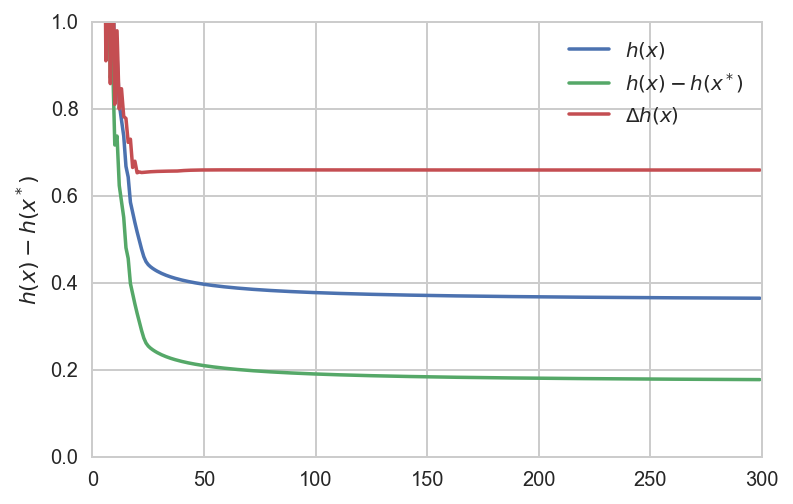

In [191]:
# initialize with a valid starting point
xsol = global_proj_x(np.zeros((len(xstar),)))
buses_wo_slack = list(filter(lambda bus: (not bus.is_slack()), mp.get_network().buses))

max_iteration = 300

# save convergence values
objective_values = []
error_values = []
dh_values = []

# show convergence plot
colors = seaborn.color_palette()
fig, ax = plt.subplots(1,1)
fig.canvas.set_window_title("Stochastic Proximal Gradient")
ax.plot(objective_values, label="$h(x)$", color=colors[0])
ax.plot(error_values, label="$h(x) - h(x^*)$", color=colors[1])
ax.plot(dh_values, label="$\Delta h (x)$", color=colors[2])
#ax.set_yscale('log')
legend()
ylabel('$h(x) - h(x^*)$')
ax.set_xlim(0, max_iteration)    
ax.set_ylim(0,1) 
fig.canvas.draw()

print("it \t obj \t \t err \t \t ||d f|| \t  alpha \t dx")

eta = 6
for iteration in range(max_iteration):
    alpha = 1/np.maximum(iteration,1)
    theta = (eta + 1) / (eta + iteration)


    xstep = np.zeros(xsol.shape)
    with multiprocessing.Pool() as pool:
        steps = pool.starmap(prox_step, [(p_bats[bus.index] * xsol - alpha * (grad_f(xsol, bus=bus) + get_noisy_vector(iteration, p_bats[bus.index].shape[0])), bus.index, alpha) for bus in buses_wo_slack])

    for i, step in enumerate(steps):
        xstep += p_bats[i].T * step

    xpre = xsol.copy()
    xsol = (1-theta) * xpre + theta * xstep
    
    error_to_centralized =  h(xsol)  - h(xstar)
    
    # Output
    objective_values.append(h(xsol))
    error_values.append(error_to_centralized)
    dh_values.append(norm(grad_h(xsol), ord=inf))
    
    # Set plot data
    ax.lines[0].set_xdata(np.arange(0, iteration+1))
    ax.lines[0].set_ydata(objective_values)
    ax.lines[1].set_xdata(np.arange(0, iteration+1))    
    ax.lines[1].set_ydata(error_values)
    ax.lines[2].set_xdata(np.arange(0, iteration+1))    
    ax.lines[2].set_ydata(dh_values)
    fig.canvas.draw()
    
    if iteration % 10 == 0:
        print("{} \t {:.2E} \t {:.2E} \t {:.2E} \t {:.2E} \t {:.2E}".format(iteration, h(xsol), error_to_centralized, norm(grad_h(xsol), ord=inf),  alpha, norm(xsol - xpre, ord=inf)))

fig.canvas.draw()
show()